In [1]:
import sys
sys.path.append('..')
from model import AudioCLIP
import utils
import torchvision as tv
import glob
import torch
import librosa
import numpy as np
import simplejpeg
from PIL import Image
aclp = AudioCLIP(pretrained=f'../../../pretrained_backbones/AudioCLIP-Full-Training.pt')
SAMPLE_RATE = 44100
IMAGE_SIZE = 224
IMAGE_MEAN = 0.48145466, 0.4578275, 0.40821073
IMAGE_STD = 0.26862954, 0.26130258, 0.27577711

audio_transforms = utils.transforms.ToTensor1D()

image_transforms = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Resize(IMAGE_SIZE, interpolation=Image.BICUBIC),
    tv.transforms.CenterCrop(IMAGE_SIZE),
    tv.transforms.Normalize(IMAGE_MEAN, IMAGE_STD)
])

/home/yujr/anaconda3/envs/audio_seg/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yujr/anaconda3/envs/audio_seg/lib/python3.7/site-packages/torchvision/transforms/transforms.py:330: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


In [11]:
paths_to_audio = glob.glob('audio/*.wav')
paths_to_audio = sorted(paths_to_audio)
audio = list()
for path_to_audio in paths_to_audio:
    track, _ = librosa.load(path_to_audio, sr=SAMPLE_RATE, dtype=np.float32)

    # compute spectrograms using trained audio-head (fbsp-layer of ESResNeXt)
    # thus, the actual time-frequency representation will be visualized
    # spec = aclp.audio.spectrogram(torch.from_numpy(track.reshape(1, 1, -1)))
    # spec = np.ascontiguousarray(spec.numpy()).view(np.complex64)
    # pow_spec = 10 * np.log10(np.abs(spec) ** 2 + 1e-18).squeeze()

    audio.append((track, None))

KeyboardInterrupt: 

In [3]:
paths_to_images = glob.glob('images/*.jpg')
paths_to_images = sorted(paths_to_images)
images = list()
for path_to_image in paths_to_images:
    with open(path_to_image, 'rb') as jpg:
        image = simplejpeg.decode_jpeg(jpg.read())
        images.append(image)

In [4]:

# AudioCLIP handles raw audio on input, so the input shape is [batch x channels x duration]
audio = torch.stack([audio_transforms(track.reshape(1, -1)) for track, _ in audio])
# standard channel-first shape [batch x channels x height x width]
images = torch.stack([image_transforms(image) for image in images])

In [5]:
import torch.nn.functional as F
def encode_audio_feature(audio):
    audio_features = aclp.encode_audio(audio=audio)
    audio_features = audio_features / audio_features.norm(dim=-1, keepdim=True)
    return audio_features


def encode_image_feature(image):
    region_aware_feature , image_features = aclp.encode_image(image=image)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    region_fine_grained_feature = region_aware_feature[-3]
    region_fine_grained_feature = region_fine_grained_feature / region_fine_grained_feature.norm(dim=1, keepdim=True)
    region_coarse_grained_feature = region_aware_feature[-1]
    region_coarse_grained_feature = region_coarse_grained_feature / region_coarse_grained_feature.norm(dim=1, keepdim=True)
    return region_fine_grained_feature, region_coarse_grained_feature, image_features

scale_audio_image = torch.clamp(aclp.logit_scale_ai.exp(), min=1.0, max=100.0)
scale_audio_text = torch.clamp(aclp.logit_scale_at.exp(), min=1.0, max=100.0)
scale_image_text = torch.clamp(aclp.logit_scale.exp(), min=1.0, max=100.0)


In [6]:
audio_features = encode_audio_feature(audio)
# audio_features: 5 x 1024 -> 10 x 1024
audio_features = audio_features.unsqueeze(1) # 5x1x1024
audio_features = audio_features.expand(-1, 2, -1) # 5x2x1024
audio_features.permute(1, 0, 2) # 2x5x1024
audio_features = audio_features.reshape(-1, audio_features.shape[-1]) # 10x1024
region_fine_grained_feature, region_coarse_grained_feature, image_features = encode_image_feature(images)

In [7]:
"""
calculate the cosine similarity between audio and image features, audio: batch x 1024, image: batch x 1024 x H x W
"""
def calculate_region_aware_similarity(audio_features, region_fine_grained_feature, region_coarse_grained_feature):
    audio_features = audio_features.unsqueeze(2).unsqueeze(3) # batch x 1024 x 1 x 1
    audio_fine_grained_features = audio_features.expand(-1, -1, region_fine_grained_feature.shape[2], region_fine_grained_feature.shape[3]) # batch x 1024 x H x W
    audio_coarse_grained_features = audio_features.expand(-1, -1, region_coarse_grained_feature.shape[2], region_coarse_grained_feature.shape[3]) # batch x 1024 x H x W
    fine_grained_similarity = torch.sum(audio_fine_grained_features * region_fine_grained_feature, dim=1) # batch x H x W
    coarse_grained_similarity = torch.sum(audio_coarse_grained_features * region_coarse_grained_feature, dim=1) # batch x H x W
    fine_grained_similarity_seq = fine_grained_similarity.view(fine_grained_similarity.shape[0], -1) # batch x (H x W)
    coarse_grained_similarity_seq = coarse_grained_similarity.view(coarse_grained_similarity.shape[0], -1) # batch x (H x W)
    
    fine_grained_similarity_seq = fine_grained_similarity_seq * scale_audio_image
    fine_grained_similarity_seq = F.softmax(fine_grained_similarity_seq, dim=1)

    coarse_grained_similarity_seq = coarse_grained_similarity_seq * scale_audio_image
    coarse_grained_similarity_seq = F.softmax(coarse_grained_similarity_seq, dim=1)

    fine_grained_softmax_similarity = fine_grained_similarity_seq.view(fine_grained_similarity.shape[0], fine_grained_similarity.shape[1], fine_grained_similarity.shape[2]) # batch x H x W
    coarse_grained_softmax_similarity = coarse_grained_similarity_seq.view(coarse_grained_similarity.shape[0], coarse_grained_similarity.shape[1], coarse_grained_similarity.shape[2]) # batch x H x W
    return fine_grained_similarity, coarse_grained_similarity, fine_grained_softmax_similarity, coarse_grained_softmax_similarity

fine_grained_similarity, coarse_grained_similarity, fine_grained_softmax_similarity,\
    coarse_grained_softmax_similarity = calculate_region_aware_similarity(audio_features, region_fine_grained_feature, region_coarse_grained_feature)
"""
viusalize attention map
"""
import matplotlib.pyplot as plt
import cv2
import simplejpeg
IMAGE_SIZE = 224
def visualize(similarity, images):
    heatmaps = []
    for i in range(similarity.shape[0]):
        image = images[i]
        image = cv2.resize(image.permute(1,2,0).detach().numpy(), (IMAGE_SIZE, IMAGE_SIZE))
        heatmap = similarity[i].detach().numpy()
        heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        heatmap = cv2.resize(heatmap, (IMAGE_SIZE, IMAGE_SIZE))
        #heatmap = heatmap * 0.4 + image * 0.6
        heatmap = np.uint8(heatmap)
        heatmaps.append(heatmap)
    return heatmaps
fine_grained_similarity = visualize(fine_grained_similarity, images)
coarse_grained_similarity = visualize(coarse_grained_similarity, images)
fine_grained_softmax_similarity = visualize(fine_grained_softmax_similarity, images)
coarse_grained_softmax_similarity = visualize(coarse_grained_softmax_similarity, images)

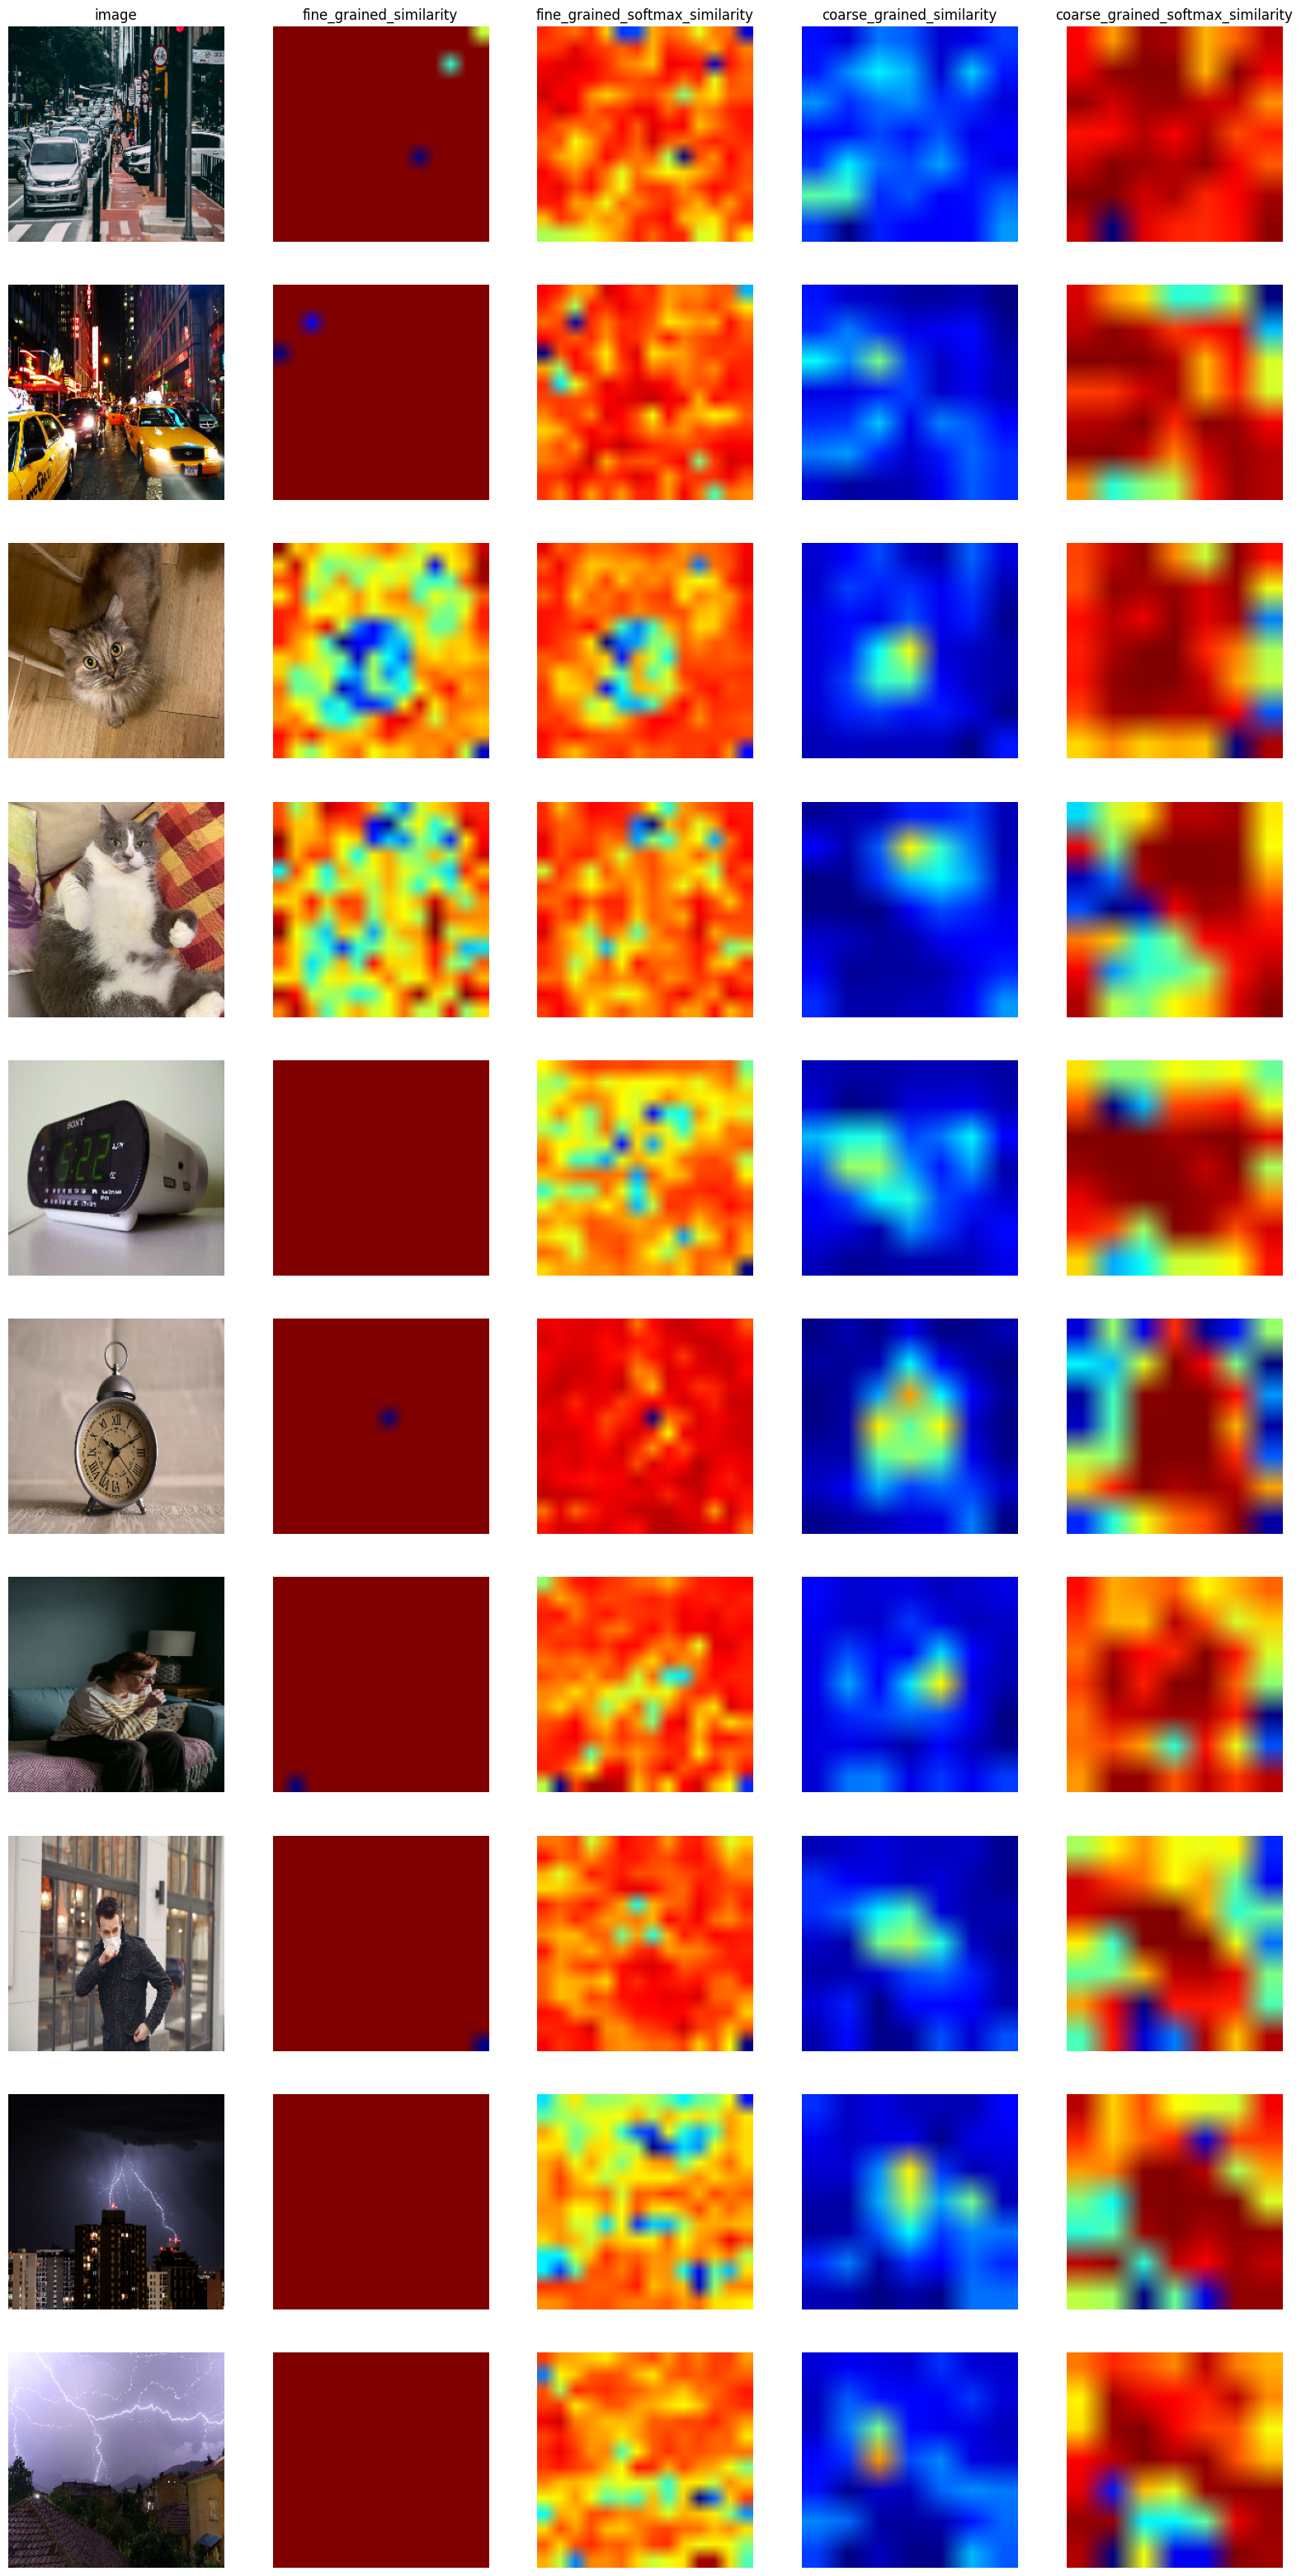

In [8]:
"""
plot 5 x len(images) subfiges
"""
fig, axes = plt.subplots(len(images), 5, figsize=(20, 40))
head = ['image', 'fine_grained_similarity', 'fine_grained_softmax_similarity', 'coarse_grained_similarity', 'coarse_grained_softmax_similarity']
for idx, jdx in np.ndindex(axes.shape):
    if idx == 0:
        axes[idx, jdx].set_title(head[jdx])
    axes[idx, jdx].axis('off')
    if jdx == 0:
        path_to_image = paths_to_images[idx]
        jpg = open(path_to_image, 'rb')
        image = simplejpeg.decode_jpeg(jpg.read())
        axes[idx, jdx].imshow(cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE)))
    elif jdx == 1:
        axes[idx, jdx].imshow(fine_grained_similarity[idx])
    elif jdx == 2:
        axes[idx, jdx].imshow(fine_grained_softmax_similarity[idx])
    elif jdx == 3:
        axes[idx, jdx].imshow(coarse_grained_similarity[idx])
    elif jdx == 4:
        axes[idx, jdx].imshow(coarse_grained_softmax_similarity[idx])

In [ ]:
paths_to_audio = glob.glob('audio/*.wav')
paths_to_audio = sorted(paths_to_audio)
audio = list()
audio_transform = transforms.Compose([
            transforms.ToTensor(),
        ])
from torchvision import transforms
from utils.transforms import ToTensor1D
from config import cfg
def load_audio_wav(audio_wav_path, transform=None):
    track, _ = librosa.load(audio_wav_path, sr=cfg.DATA.SAMPLE_RATE, dtype=np.float32)
    #track = track.detach() # [220500] TODO: => [5, XXXX]
    # 30 of 4925 less than 5s, TODO: padding last 1s to 5s
    MAX_LENGTH = 5 * cfg.DATA.SAMPLE_RATE
    if track.shape[0] > MAX_LENGTH:
        track = track[:MAX_LENGTH]
    elif track.shape[0] < MAX_LENGTH:
        second = track.shape[0] // cfg.DATA.SAMPLE_RATE
        rest_second = 5 - second
        last_second_feature = track[-cfg.DATA.SAMPLE_RATE:]
        track = track[0:second*cfg.DATA.SAMPLE_RATE]
        track = np.concatenate((track, np.tile(last_second_feature, rest_second)))
    track = track.reshape(1, -1)
    track = transform(track)
    track = track.reshape(5, 1, -1) # 5 x 1 x 44100
    track = track.repeat((1, 1, 5))
    return track

a = load_audio_wav(paths_to_audio[0], transform=audio_transform)
a.shape